In [36]:
import pandas as pd
import time
import numpy as np
#from sklearn.cross_validation import train_test_split
import xgboost as xgb
import gc

In [37]:
# read_file

path = 'dataset/'
start_time = time.time()
train = pd.read_csv(path+"train.csv", skiprows=160000000, nrows=60000000)
test = pd.read_csv(path+"test.csv")
train.columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time', 'is_attributed']
print('[{}] Finished loading data'.format(time.time() - start_time))
train.head()

[86.2894232273] Finished loading data


,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,11846,12,1,13,259,2017-11-09 08:17:26,NaN,0
1,5147,19,0,0,347,2017-11-09 08:17:26,NaN,0
2,11782,9,1,8,127,2017-11-09 08:17:26,NaN,0
3,33867,35,1,19,21,2017-11-09 08:17:26,2017-11-09 09:05:37,1
4,110589,3,1,23,280,2017-11-09 08:17:26,NaN,0


In [38]:
def dataPreProcessTime(df):
    df['datetime'] = pd.to_datetime(df['click_time'])
    df['dow']      = df['datetime'].dt.dayofweek.astype(int)
    df['month']    = df['datetime'].dt.month.astype(int)
    df['hour']     = df['datetime'].dt.hour.astype(int)
    df['day']      = df['datetime'].dt.day.astype(int)
    #df.drop(['click_time','datetime'], axis=1, inplace=True)
    return df
def feature_clicksofip(df):
    ip_count = df.groupby(['ip'])['os'].count().reset_index()
    ip_count.columns = ['ip', 'clicks_by_ip']
    merge = pd.merge(df, ip_count, on='ip', how='left', sort=False)
    merge['clicks_by_ip'] = merge['clicks_by_ip'].astype('uint16')
    #merge.drop('ip', axis=1, inplace=True)
    return merge

def feature_ipdayhour(df):
    ipdayhour = df[['ip','day','hour','channel']].groupby(by=['ip','day','hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_day_hour'})
    train_df = df.merge(ipdayhour, on=['ip','day','hour'], how='left')
    return train_df

def feature_ipapp(df):
    ip_app = df[['ip', 'app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app'})
    train_df = df.merge(ip_app, on=['ip','app'], how='left')
    return train_df

def feature_ipappos(df):
    ipappos = df[['ip','app', 'os', 'channel']].groupby(by=['ip', 'app', 'os'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_os'})
    train_df = df.merge(ipappos, on=['ip','app', 'os'], how='left')
    return train_df

def merge_feature(df):
    train = dataPreProcessTime(df)
    train = feature_clicksofip(train)
    train = feature_ipdayhour(train)
    train = feature_ipapp(train)
    train = feature_ipappos(train)
    return train

train=merge_feature(train)
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,datetime,dow,month,hour,day,clicks_by_ip,ip_day_hour,ip_app,ip_app_os
0,11846,12,1,13,259,2017-11-09 08:17:26,NaN,0,2017-11-09 08:17:26,3,11,8,9,136,13,23,7
1,5147,19,0,0,347,2017-11-09 08:17:26,NaN,0,2017-11-09 08:17:26,3,11,8,9,38794,5091,743,233
2,11782,9,1,8,127,2017-11-09 08:17:26,NaN,0,2017-11-09 08:17:26,3,11,8,9,833,51,127,6
3,33867,35,1,19,21,2017-11-09 08:17:26,2017-11-09 09:05:37,1,2017-11-09 08:17:26,3,11,8,9,457,55,1,1
4,110589,3,1,23,280,2017-11-09 08:17:26,NaN,0,2017-11-09 08:17:26,3,11,8,9,3266,324,735,9


In [39]:
train_y = train['is_attributed']
# add inplace=True 直接替换
train_x = train.drop(['is_attributed', 'attributed_time','ip','click_time','datetime'], axis=1)
train_x.head()
del train
gc.collect()

3665

In [40]:
sub = pd.DataFrame()
sub['click_id'] = test['click_id']
test.drop('click_id', axis=1, inplace=True)

print('[{}] Start XGBoost Training'.format(time.time() - start_time))

[275.819951057] Start XGBoost Training


In [41]:
params = {'eta': 0.1, 
          'max_depth': 5, 
          'subsample': 0.9, 
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'min_child_weight':1,
          'alpha':4,
          'objective': 'binary:logistic', 
          'eval_metric': 'auc', 
          'random_state': 99, 
          'scale_pos_weight': 150,
          'silent': True}

In [42]:
from sklearn.model_selection import StratifiedKFold
num_folds = 5
seed = 7 
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

valid_result = []
for train_index, test_index in kf.split(train_x, train_y):
    evals_result = {}
    watchlist = [(xgb.DMatrix(train_x.iloc[train_index], train_y.iloc[train_index]), 'train'), (xgb.DMatrix(train_x.iloc[test_index], train_y.iloc[test_index]), 'valid')]
    dtrain = xgb.DMatrix(train_x.iloc[train_index], train_y.iloc[train_index])
    model = xgb.train(params, dtrain, 400 , watchlist, maximize=True, verbose_eval=10,evals_result=evals_result,early_stopping_rounds = 400)
    valid_result.append( evals_result['valid']['auc'][-1])
print('[{}] Finish XGBoost Training'.format(time.time() - start_time))

[0]	train-auc:0.882113	valid-auc:0.883417
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 400 rounds.
[10]	train-auc:0.960345	valid-auc:0.961365
[20]	train-auc:0.962451	valid-auc:0.963541
[30]	train-auc:0.964903	valid-auc:0.966012
[40]	train-auc:0.967555	valid-auc:0.968315
[50]	train-auc:0.969669	valid-auc:0.970198
[60]	train-auc:0.970955	valid-auc:0.971424
[70]	train-auc:0.97243	valid-auc:0.972649
[80]	train-auc:0.97351	valid-auc:0.973516
[90]	train-auc:0.974298	valid-auc:0.974119
[100]	train-auc:0.975077	valid-auc:0.97456
[110]	train-auc:0.975762	valid-auc:0.974972
[120]	train-auc:0.976233	valid-auc:0.975282
[130]	train-auc:0.97674	valid-auc:0.975559
[140]	train-auc:0.977092	valid-auc:0.97575
[150]	train-auc:0.977529	valid-auc:0.975943
[160]	train-auc:0.977837	valid-auc:0.976109
[170]	train-auc:0.978141	valid-auc:0.976207
[180]	train-auc:0.978396	valid-auc:0.976275
[190]	train-auc:0.978668	valid-auc:0

[90]	train-auc:0.974384	valid-auc:0.972781
[100]	train-auc:0.975015	valid-auc:0.973307
[110]	train-auc:0.975572	valid-auc:0.973785
[120]	train-auc:0.976167	valid-auc:0.974201
[130]	train-auc:0.976628	valid-auc:0.974486
[140]	train-auc:0.977051	valid-auc:0.974759
[150]	train-auc:0.97741	valid-auc:0.975029
[160]	train-auc:0.977747	valid-auc:0.975261
[170]	train-auc:0.978051	valid-auc:0.975438
[180]	train-auc:0.978304	valid-auc:0.975597
[190]	train-auc:0.978566	valid-auc:0.975705
[200]	train-auc:0.978871	valid-auc:0.975842
[210]	train-auc:0.979199	valid-auc:0.976074
[220]	train-auc:0.979432	valid-auc:0.97619
[230]	train-auc:0.979653	valid-auc:0.976273
[240]	train-auc:0.979922	valid-auc:0.976349
[250]	train-auc:0.980153	valid-auc:0.976425
[260]	train-auc:0.980372	valid-auc:0.976485
[270]	train-auc:0.980574	valid-auc:0.976527
[280]	train-auc:0.980724	valid-auc:0.976553
[290]	train-auc:0.980884	valid-auc:0.97657
[300]	train-auc:0.981026	valid-auc:0.976627
[310]	train-auc:0.981201	valid-auc:0

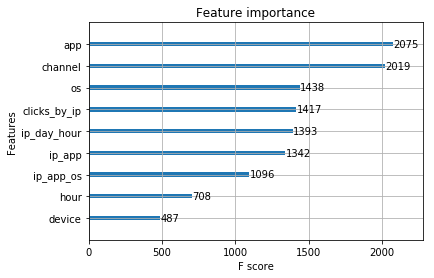

In [43]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plot_importance(model)
plt.gcf().savefig('feature_importance_xgb.png')

In [44]:
mean_result = reduce(lambda x, y: x + y, valid_result)/len(valid_result)
print mean_result

0.9767834


In [45]:
# deal with the test data
test=merge_feature(test)
test.drop(['ip','click_time','datetime'], axis=1, inplace=True)
test.head()

,app,device,os,channel,dow,month,hour,day,clicks_by_ip,ip_day_hour,ip_app,ip_app_os
0,9,1,3,107,4,11,4,10,91,34,28,1
1,9,1,3,466,4,11,4,10,2083,403,289,5
2,21,1,19,128,4,11,4,10,2135,229,312,24
3,15,1,13,111,4,11,4,10,1201,239,42,23
4,12,1,13,328,4,11,4,10,208,60,24,7


In [46]:
sub['is_attributed'] = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit)
sub.to_csv('xgb_sub.csv',index=False)